BatchNorm 一维批量归一化
BatchNorm1d是一种归一化层，主要用于处理一维数据，如时间序列或特征向量。它通过标准化输入，使训练更加稳定，加快收敛速度。
通常放在产生特征的层（Linear/Conv1d）后面、非线性激活（ReLU/GELU 等）前面，
MLP： Linear → BatchNorm1d → Activation
1D CNN（时序/音频/传感器）： Conv1d → BatchNorm1d → Activation

https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d

1.基本上是现代神经网络的标配，building block

2.Norm一般指对输入层进行Norm

3.BN：BatchNorm 是对每一个层的输入，即前一层的输出进行BN

4.Norm的关键就是 0 mean均值 1标准差 ，以及多了可选配(affine=Treu)的仿射变换的可学习的α和β参数

5.不改变shape
1d： [N,D] >[N,D]
2d:[N,C,H,W]>[N,C,H,W]
3d:[N,C,D,H,W]>[N,C,D,H,W]

6.基于Batch粒度的，批次内特征的归一化。按照batch效率更高。

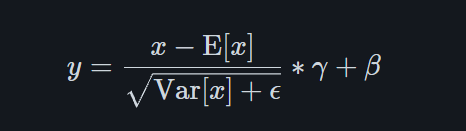

优点：
1.训练更快，收敛更快，更稳定
2.部分解决过拟合问题


affine（仿射变换），指的是：在标准化之后，再对每个通道做一次“缩放 + 平移”的线性变换，并且这个缩放和平移是可学习参数。
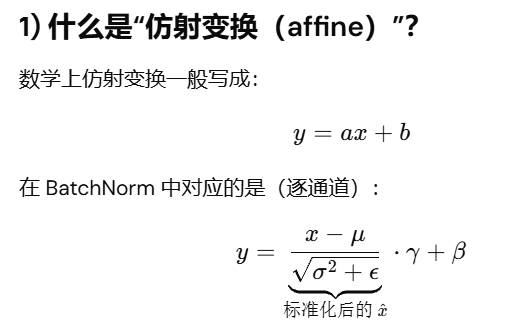
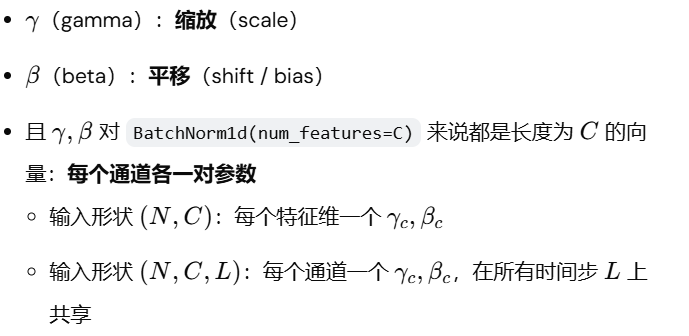

affine=True/False 分别意味着什么？
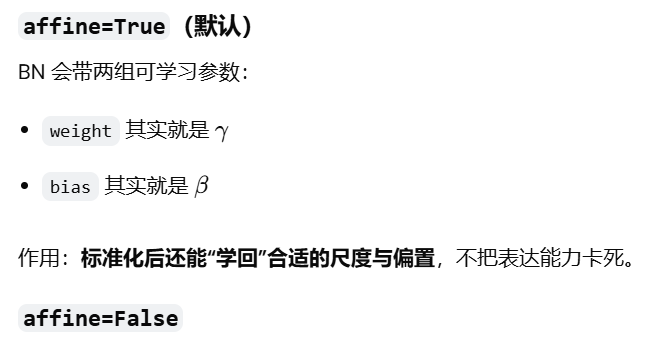
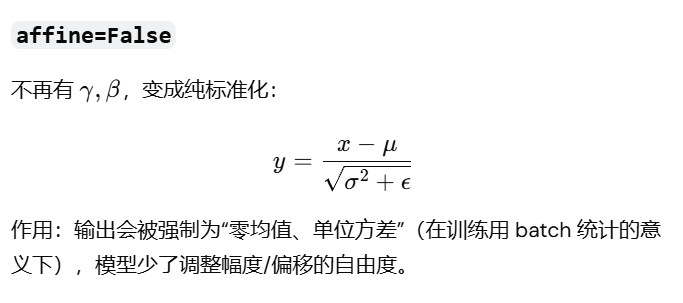


为什么 BN 需要这个 affine？
直觉：标准化把分布“拉齐”了，但网络可能需要某个通道更大/更小的幅度，或者需要整体偏移来适配下一层。
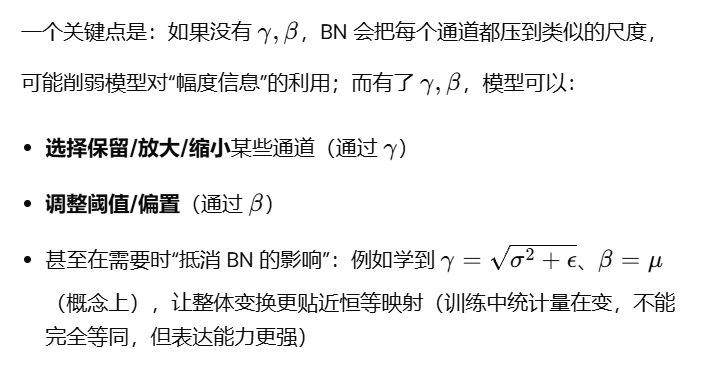


track_running_stats=True 和 affine 的关系（容易混淆）
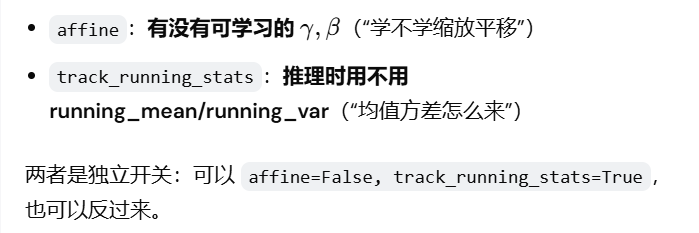


标准化的意义：
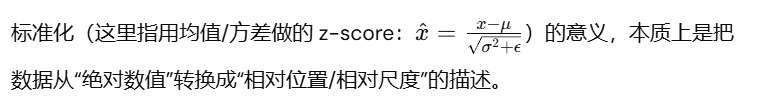

标准化之后的数据主要体现 
1.相对均值的偏离程度（偏离多少个标准差）
2.把不同特征的尺度拉到同一量级：
不同特征原本可能量纲不同（米/毫米、人数/金额）、范围不同（0–1 vs 0–10000）。标准化后都被拉到“均值约为 0、方差约为 1”的统一尺度，便于模型用同一种学习率和权重尺度去处理。

标准化的特点：
1) 对“平移 + 缩放”不敏感（关键性质）
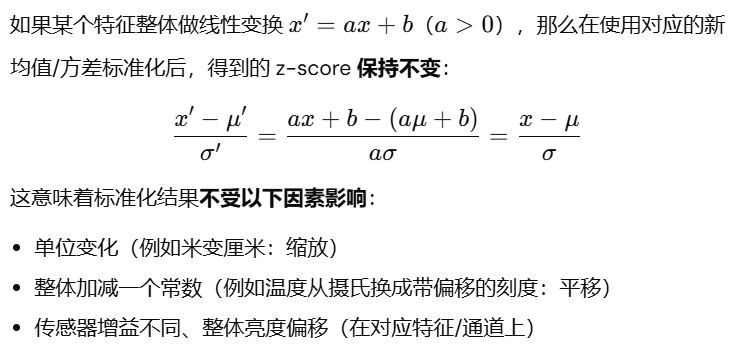
2) 更利于数值优化与稳定训练（在神经网络中）
把各层激活拉到可控的尺度范围，常带来：
梯度更稳定（减少某些维度过大/过小导致的训练困难）
收敛更快（很多情况下）

标准化会受这些因素影响（也需要你注意）：
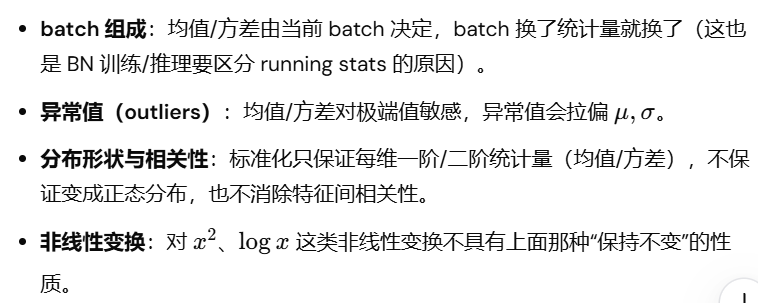


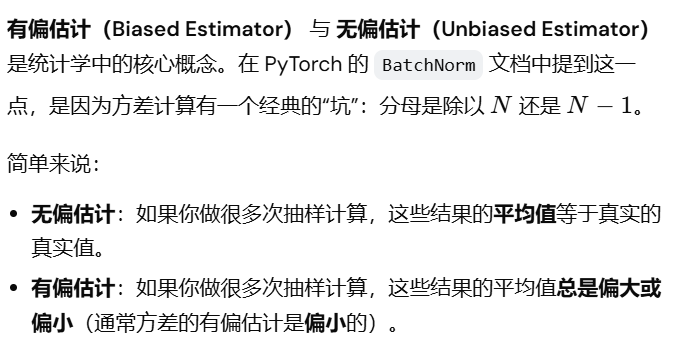
训练时的前向计算中，方差使用有偏估计，等价于 torch.var(input, correction=0)
correction=0 相当于除以 n（而不是 n−1），这是 BN 常见实现细节。

但用于保存到“方差的移动平均（running_var）”里的数值使用无偏估计，等价于 torch.var(input, correction=1)。

correction=1 相当于除以 n−1。注意：前向用的方差和存到 running_var 的方差可能计算口径不同

默认情况下，训练时该层会维护（更新）均值与方差的运行估计（running estimates），并在评估/推理（evaluation）时用它们来做归一化。运行估计的默认 momentum 为 0.1。
即 model.train()：用 batch 的统计量做归一化，同时更新 running_mean/running_var。
model.eval()：用 running_mean/running_var 做归一化（更稳定）。

但是如果把 track_running_stats=False，该层就不保存运行统计量；评估/推理时也改为使用 batch 统计量。
这会让推理结果依赖当前输入 batch（不一定稳定），但在某些分布变化/小数据场景可能有人会这样做。


因为 BN 是沿 C 维进行的（对每个通道分别归一化），统计量是在 
(N,L) 的切片上计算的，所以常把它称为“时间（序列）批量归一化（Temporal Batch Normalization）”。

参数：
num_features (int) – 输入的特征数/通道数 C
eps (float) –加到分母上的小常数，保证数值稳定。默认 1e-5
momentum (float | None) – 用于计算 running_mean 和 running_var 的系数。设为 None 时使用累计移动平均（简单平均）。默认 0.1。
affine (bool) – 为 True 时，该模块带可学习的仿射参数（γ,β）。默认 True。
track_running_stats (bool) –为 True 时跟踪（维护）运行均值与方差；为 False 时不跟踪，并把缓冲区 running_mean、running_var 初始化为 None。当这些缓冲区为 None 时，无论训练还是评估模式都总是使用 batch 统计量。默认 True。

形状：
输入：
(N,C) 或 (N,C,L)。其中 N 是 batch 大小，C 是特征/通道数，L 是序列长度。
输出：
(N,C) 或 (N,C,L)，与输入形状相同。

文档：
https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d
Code：
https://github.com/pytorch/pytorch/blob/v2.10.0/torch/nn/modules/batchnorm.py#L279

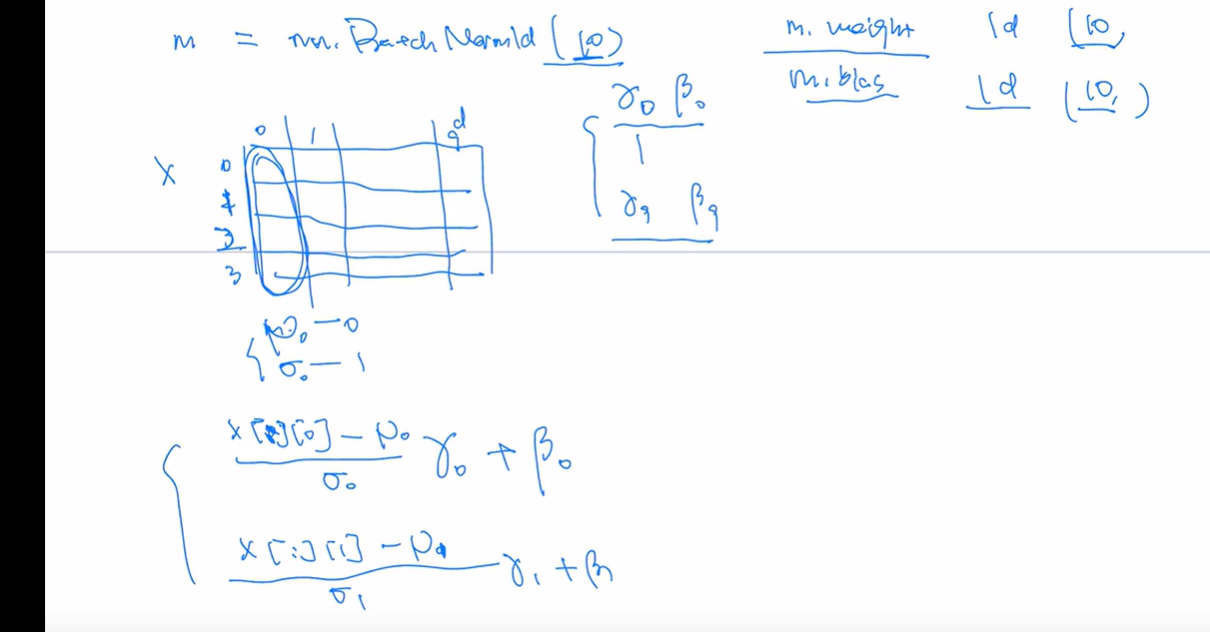
1d 的情况下假如输入：
x = torch.random(4,10)
batch = 4,4个样本为一个批次，单个样本的维度是10，
如图所示，在求均值和方差进行归一化的时候，会对同一批次的每一个维度计算均值和方差，
即会有E0 。。。。。E9
方差0.......方差9
每一组都有对应的可以学习的α0.。。。α9 和β0.。。。。β9 对应的可学习的w和b也都是1d 10维的

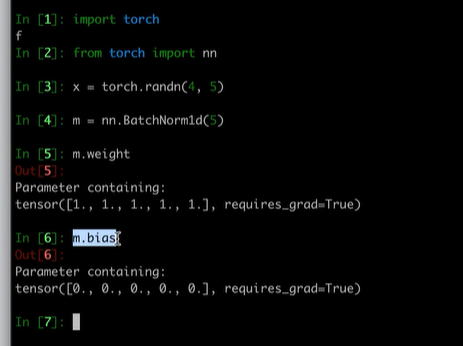

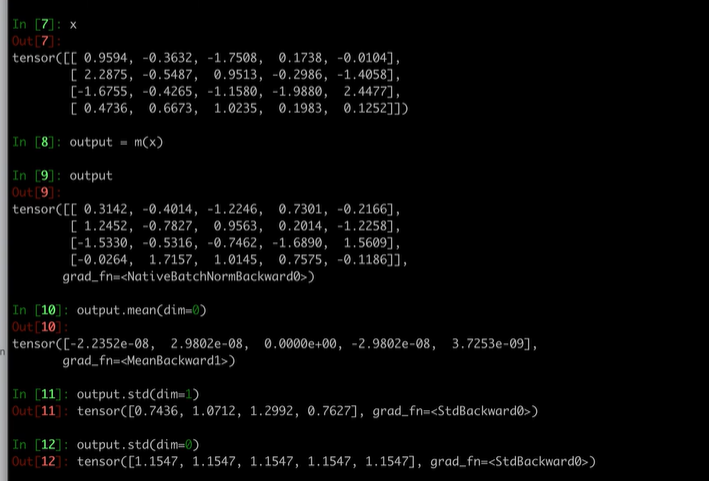
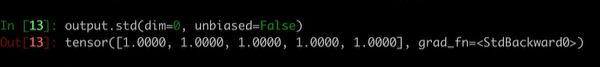
 1d 例子

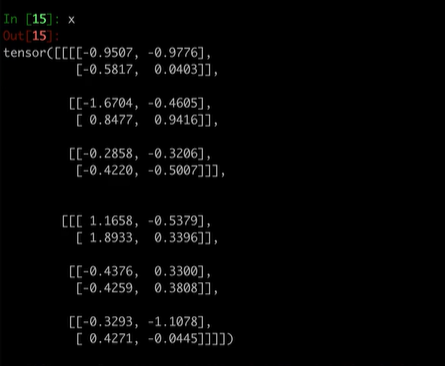
2d例子，声明BN2d时维度和通道维度C保持一致
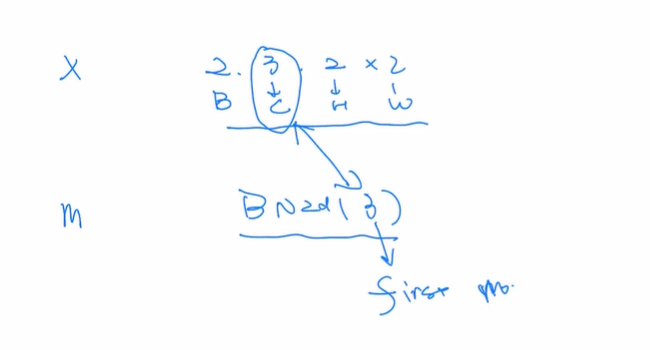
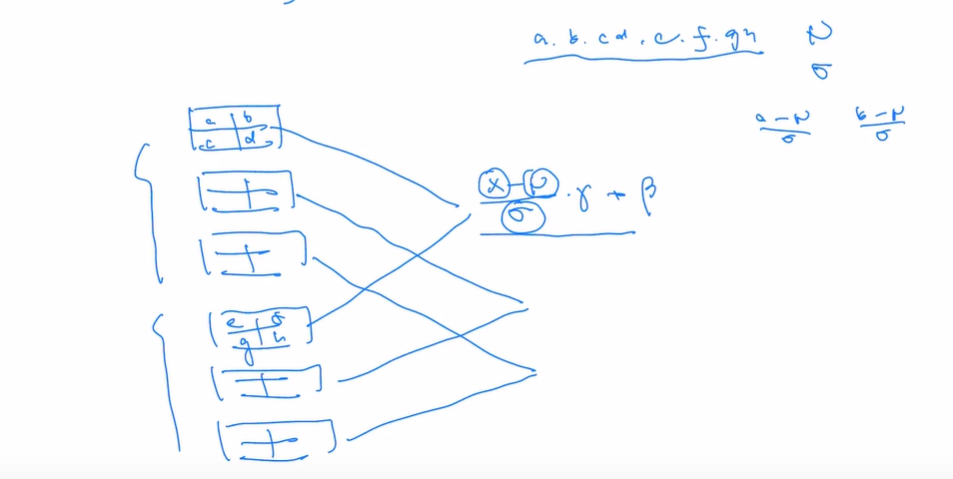



输入 2样本即batch维度， 3通道 宽高 2*2
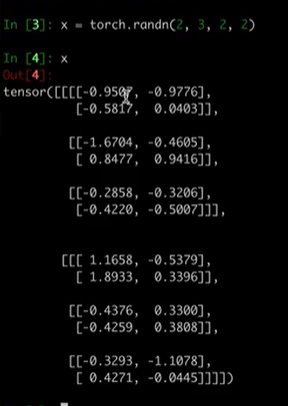
 按照通道维度（遍历通道），去做归一化（非batch的第一个维度），即
 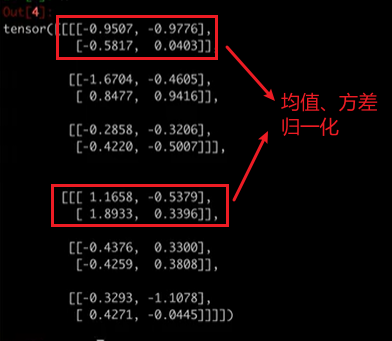
 